In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from model.mrcnn.config import Config
from model.mrcnn import utils
import model.mrcnn.model as modellib
from model.mrcnn import visualize
from model.mrcnn.model import log
from model.mrcnn import data_generator as datagen
from model.mrcnn import image_meta as meta
from model.mrcnn import dataset

%matplotlib inline 

Using TensorFlow backend.


In [4]:
from data.openimage.oid_first import OIDataset

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.environ['HOME'], 'partial_experiments')

# Local path to trained weights file MEH
COCO_MODEL_PATH = os.path.join(os.environ['HOME'], "partial-labels/experiments/frcnn", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
class OIDConfig(Config):
    """
    Configuration for training on the OID dataset.
    Derives from the base Config class and overrides values specific to OID
    """
    # Give the configuration a recognizable name
    NAME = "openimages"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NB_CLASSES = 500 + 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (64, 128, 256)  # anchor side in pixels
    
    # STEPS_PER_EPOCH = 2000   # Size of the dataset
    STEPS_PER_EPOCH = 3000
    NB_EPOCH = 200
    
    # old config
    IMG_SIZE = 448
    DATASET_PATH = '/local/DEEPLEARNING/oid/'
    NB_CHANNELS = 3
    
config = OIDConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   /local/DEEPLEARNING/oid/
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                513
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
IMG_SIZE                       448
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_l

## val dataset

In [7]:
# Validation dataset
dataset_val = OIDataset()
dataset_val.load_oid(config.DATASET_PATH, 8, 'val', config)
dataset_val.prepare()

loaded annotations in 97.37873864173889
Registered images in 0.13690972328186035


## model

In [8]:
class InferenceConfig(OIDConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [9]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# /home/caleml/partial_experiments/exp_20200115_1952_frcnn_baseline_oid_baseline/openimages20200115T2023/mask_rcnn_openimages_{epoch:04d}.h5
model_path = os.path.join('/home/caleml/partial_experiments/exp_20200115_1952_frcnn_baseline_oid_baseline/openimages20200115T2023/', 'mask_rcnn_openimages_0200.h5')
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/caleml/partial_experiments/exp_20200115_1952_frcnn_baseline_oid_baseline/openimages20200115T2023/mask_rcnn_openimages_0200.h5
Re-starting from epoch 200


## examples

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

32766
original_image           shape: (448, 448, 3)         min:    0.00000  max:  255.00000  float32
image_meta               shape: (513,)                min:    0.00000  max: 32766.00000  int64
gt_class_id              shape: (27,)                 min:   30.00000  max:  339.00000  int64
gt_bbox                  shape: (27, 4)               min:    0.00000  max:  447.62682  float64


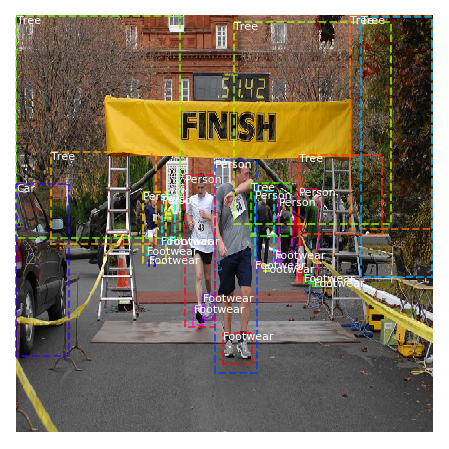

In [17]:

image_id = random.choice(dataset_val.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)

visualize.display_instances(original_image, gt_bbox, gt_class_id, dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 513)              min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 49392, 4)         min:   -0.40496  max:    1.36917  float32
[{'rois': array([[177,   0, 352,  57],
       [  2, 351, 264, 445],
       [  1,   0, 209, 144],
       [152, 207, 371, 260]], dtype=int32), 'class_ids': array([ 64,  30,  30, 114], dtype=int32), 'scores': array([0.85548633, 0.83858526, 0.8306103 , 0.8190393 ], dtype=float32)}]


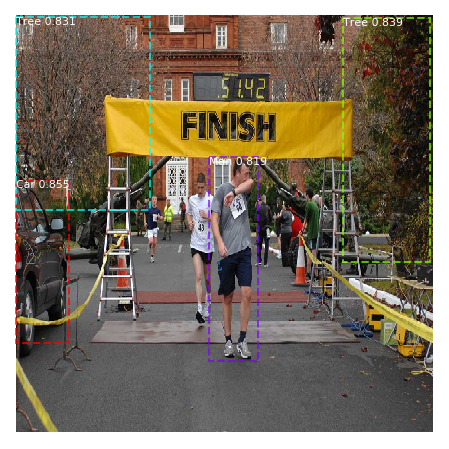

In [18]:
results = model.detect([original_image], verbose=1)

print(results)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())

## eval

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1000)
# image_ids = dataset_val.image_ids

APs = []
count = 0

for image_id in image_ids:
    count += 1
    if count % 1000 == 0:
        print("done %s val images, temp AP %s" % (count, np.mean(APs)))
    
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

done 1000 val images, temp AP 0.25793326817658707
mAP:  0.2576753349084105
